FGSM on a neat

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import random
import math
import time
import sys
import os

sys.path.append(os.path.abspath("./neat"))

from nn import *
from mutation import *
from speciation import *

random.seed(42)
torch.manual_seed(42)

In [5]:
# MNIST

ds = 'mnist'

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Subset

class Flatten:
    def __call__(self, x):
        return x.view(-1)  # flatten 1x28x28 to 784
    
transform = transforms.Compose([
    transforms.ToTensor(),    # (1, 28, 28)
    transforms.Normalize((0.1307,), (0.3081,)),  # Note: normalization expects channel dim, so do before squeeze if needed
    Flatten()
])

# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Subset stuff
train_size = len(train_dataset) // 100
test_size = len(test_dataset) // 100

train_subset = Subset(train_dataset, torch.randperm(len(train_dataset))[:train_size])
test_subset = Subset(test_dataset, torch.randperm(len(test_dataset))[:test_size])

train_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)
test_loader = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

# sklearn

# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split

# digits = load_digits()

# data_tensor = torch.tensor(digits.data, dtype=torch.float32)
# data_tensor = torch.tensor(digits.data / 16.0, dtype=torch.float32) # Normalize for neat
# target_tensor = torch.tensor(digits.target, dtype=torch.long)

# # 80/20 split
# X_train, X_test, y_train, y_test = train_test_split(
#     data_tensor, target_tensor, test_size=0.2, random_state=42, shuffle=True
# )

# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# # Batch is the full size because there is no backpropogation
# train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [6]:
# FFN to compare

class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 10, bias=False),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)

        logits = self.linear_relu_stack(x)
        return logits
    
# Training loop

fnn_model = FFN()

epochs = 100

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(fnn_model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(fnn_model.parameters(), lr=0.1)  # Higher lr to compensate for simplicity
for i in range(epochs):
    for data_batch, label_batch in train_loader:
        output = fnn_model(data_batch)
        loss = loss_fn(output, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 100 == 0:
        print(loss.item())

# Evaulate
fnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        data = data
        labels = labels
        
        outputs = fnn_model(data)  # logits
        predicted = torch.argmax(outputs, dim=1)  # class indices

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


2.320467710494995
Accuracy: 90.00%


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 1, 8, 8)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # output: 16 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # output: 32 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2)  # output: 32 x 4 x 4
        )
        self.fc = nn.Linear(32 * 4 * 4, 10)  # final output for 10 classes

    def forward(self, x):
        x = self.conv_layers(x)        # conv layers
        x = x.view(x.size(0), -1)     # flatten
        logits = self.fc(x)            # linear layer to logits
        return logits


In [184]:
# Training loop

base_m = SimpleCNN()

epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fnn_model.parameters(), lr=0.001)

for i in range(epochs):
    for data_batch, label_batch in train_loader:
        output = fnn_model(data_batch)
        loss = loss_fn(output, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 100 == 0:
        print(loss.item())

0.0029288879595696926


In [ ]:
# Init stuff

# Hyperparameters
input_dim = 8*8
output_dim = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
neat_model = torch.load("./models/sklearn_digits_100pop_2000epoch_real96.67.pth", weights_only=False)
# fnn_model = torch.load("./models/fnn97.29.pth", weights_only=False)

In [190]:
import matplotlib.pyplot as plt

def plot_img(img, label=None):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray_r')
    if label is not None:
        plt.title(f"Label: {label}")
        
    plt.tight_layout()
    plt.show()

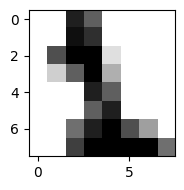

In [201]:
plot_img(X_test[5].view(8,8))

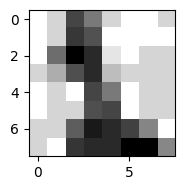

In [202]:
plot_img(FGSM(fnn_model, X_test[5], y_test[5], 0.1).view(8,8))

In [ ]:
def FGSM(model, img, target, scalar=.01):
    img = img.clone().view(1, -1).requires_grad_(True)  # Input usually doesnt require grad
    y = model(img)
    
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(y, target.view(1))

    loss.backward()
    grad = img.grad.data
    signed_grad = grad.sign()
    mod_img = img + (scalar * signed_grad)
    return mod_img.detach()

In [ ]:
def PGD(model, img, target, c=False, epsilon=3, alpha=0.01, iters=20):
    """
    model: neural network model
    img: original input image (tensor)
    target: ground truth label (tensor)
    epsilon: max perturbation size
    alpha: step size per iteration
    iters: number of iterations
    """
    # Make a copy of the original image to compare for projection
    ori_img = img.clone().detach()
    
    # Initialize perturbed image with the original
    perturbed_img = img.clone().detach().requires_grad_(True)
    
    loss_fn = nn.CrossEntropyLoss()
    
    for i in range(iters):
        if not c:
            outputs = model(perturbed_img.view(1, -1))
        else:
            outputs = model(perturbed_img.view(8, 8).unsqueeze(0).unsqueeze(0))

        loss = loss_fn(outputs, target.view(1))
        
        model.zero_grad()
        if perturbed_img.grad is not None:
            perturbed_img.grad.data.zero_()
        
        loss.backward()
        
        # Take a step in direction of gradient sign
        grad_sign = perturbed_img.grad.data.sign()
        perturbed_img = perturbed_img + alpha * grad_sign
        
        # Project back into the epsilon-ball around original image
        diff = torch.clamp(perturbed_img - ori_img, min=-epsilon, max=epsilon)
        perturbed_img = torch.clamp(ori_img + diff, min=0, max=1).detach()  # clamp to valid image range
        perturbed_img.requires_grad_()
    
    return perturbed_img.detach()
    

In [ ]:
# Evaulate

# Transfer attack

fnn_correct = 0
neat_correct = 0

total = 0

for i in range(len(y_test)):

    # data_fnn = FGSM(fnn_model, X_test[i], y_test[i]).unsqueeze(0) 


    outputs = fnn_model(X_test[i].unsqueeze(0))  # logits
    predicted = torch.argmax(outputs, dim=1)  # class indices

    fnn_correct += (predicted == y_test[i]).sum().item()

    # data_neat = FGSM(neat_model, X_test[i], y_test[i]).unsqueeze(0)
    # print(X_test[i].shape)
    # print(data_neat.shape)
    outputs = neat_model(X_test[i].unsqueeze(0))  # logits
    predicted = torch.argmax(outputs, dim=1)  # class indices
    
    neat_correct += (predicted == y_test[i]).sum().item()

    total += 1

fnn_accuracy = fnn_correct / total
neat_accuracy = neat_correct / total

print(f"fnn Accuracy: {fnn_accuracy * 100:.2f}%")
print(f"neat Accuracy: {neat_accuracy * 100:.2f}%")

fnn Accuracy: 95.56%
neat Accuracy: 96.67%
